# Load Dataset

### Load players df and fixtures df

In [1977]:
import pandas as pd
import requests
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

def get_player_data():
    players_df = pd.read_csv('players1.csv')
    return players_df

def get_fixtures():
    fixtures_df = pd.read_csv('fixtures1.csv')
    return fixtures_df

# Fetch the data
players_df = get_player_data()
fixtures_df = get_fixtures()


In [1978]:
import pandas as pd
# Remove the limit on the number of columns displayed
pd.set_option('display.max_columns', None)

## All Necessary Functions

### Calculate FDR (5 fixtures)

In [1981]:
def calculate_average_fdr():
        remaining_fixtures = fixtures_df[fixtures_df['finished'] == True]
        fdr_values = []
        remaining_fixtures = remaining_fixtures.sort_values(by='kickoff_time')
        for team in set(remaining_fixtures['team_h']).union(set(remaining_fixtures['team_a'])):
            team_fixtures = remaining_fixtures[
                (remaining_fixtures['team_h'] == team) | (remaining_fixtures['team_a'] == team)
            ].head(1) 
            for idx, fixture in team_fixtures.iterrows():
                if fixture['team_h'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_h_difficulty']})
                elif fixture['team_a'] == team:
                    fdr_values.append({'team': team, 'fdr': fixture['team_a_difficulty']})
        fdr_df = pd.DataFrame(fdr_values)
        average_fdr = fdr_df.groupby('team')['fdr'].mean().reset_index()
        average_fdr.columns = ['team_id', 'average_fdr']
        return average_fdr
    
def add_average_fdr(players_df):
        print(players_df.columns)
        # Get average FDR for each team
        average_fdr = calculate_average_fdr()
    
        # Map team names back to their IDs
        team_mapping = {
            1: 'Arsenal', 2: 'Aston Villa', 3: 'Bournemouth', 4: 'Brentford',
            5: 'Brighton', 6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton',
            9: 'Fulham', 10: 'Ipswich', 11: 'Leicester', 12: 'Liverpool',
            13: 'Man City', 14: 'Man Utd', 15: 'Newcastle', 16: 'Nottingham Forest',
            17: 'Southampton', 18: 'Spurs', 19: 'West Ham', 20: 'Wolves'
        }
        
        # Map team names
        average_fdr['team_name'] = average_fdr['team_id'].map(team_mapping)
        # Original team mapping
        
        # Reverse the mapping
        reversed_team_mapping = {name: id_ for id_, name in team_mapping.items()}
        
        # Map the 'team' column
        players_df['team_id'] = players_df['team'].map(reversed_team_mapping)

        # Invert the average FDR
        max_fdr = average_fdr['average_fdr'].max()
        average_fdr['adjusted_fdr'] = 7 - average_fdr['average_fdr']
        # average_fdr.drop(columns = ['web_name'])

        players_df = players_df.merge(
        average_fdr[['team_id', 'adjusted_fdr', 'average_fdr']],
        how='left',
        on='team_id',
        suffixes=('', '_avg')
        )
            # Check for and drop any duplicates
        players_df = players_df.loc[:, ~players_df.columns.duplicated()]

        return players_df

#### Handling missing values for players df

In [1983]:
# Dropping irrelevant columns from players_df
irrelevant_columns_players = [
    'squad_number',
    'region',
    'corners_and_indirect_freekicks_order',
    'chance_of_playing_this_round',
    'news_added',
    'chance_of_playing_next_round',
    'code', 'first_name', 'second_name', 'photo', 'news','direct_freekicks_text','penalties_text','transfers_in','transfers_out'
]

# These columns are not important because we have other columns in the dataset that tells the same thing. 

players_df_cleaned = players_df.drop(columns=irrelevant_columns_players, errors='ignore')

let's inspect direct_freekicks_order and penalties_order .. they are crucial for prediction

In [1985]:

# Replace 'column_name' with the name of the column you want to check
print(players_df_cleaned['direct_freekicks_order'].unique())

print(players_df_cleaned['penalties_order'].unique())

[nan  1.  2.  4.  3.  5.]
[nan  3.  2.  1.  4.]


Fill out nan with 0 because they are non relevant. We might have to think in the future how to give importance to 2 when 1 is injured..

In [1987]:
# Replace NaN values in 'direct_freekick_order' and 'penalties_order' with 0
players_df_cleaned['direct_freekicks_order'] = players_df_cleaned['direct_freekicks_order'].fillna(0)
players_df_cleaned['penalties_order'] = players_df_cleaned['penalties_order'].fillna(0)

In [1988]:
# Assuming the original status values are 'i' for injured, 'u' for unavailable, and 'a' for available
players_df = players_df[~players_df['status'].isin(['i', 'u'])]
players_df_cleaned = players_df_cleaned[~players_df_cleaned['status'].isin(['i', 'u'])]

Let's inspect fixtures_df to see whether the team_h_score and team_a_score have what sort of missing values.(home goals and away goals)

In [1990]:
# Filter rows where either team_h_score or team_a_score is null
missing_scores_df = fixtures_df[(fixtures_df['team_h_score'].isnull()) | (fixtures_df['team_a_score'].isnull())]

Given the information, it's future fixtures so we leave this as NaN for now. We don't delete this because we need to calculate average fdr later. 

In [1992]:
# Feature engineer players value through totalpoint/cost

In [1993]:
players_df_cleaned['value'] = players_df_cleaned['total_points'] / players_df_cleaned['now_cost']

## EDA and feature selection:

In [1995]:
# Step 2: Label encoding for the 'status' column
if 'status' in players_df.columns:
    le = LabelEncoder()
    players_df_cleaned['status'] = le.fit_transform(players_df_cleaned['status'])

In [1996]:
import pandas as pd

# Filter for object (dtype('O')) and boolean (dtype('bool')) columns
object_bool_columns = players_df_cleaned.select_dtypes(include=['object', 'bool'])


In [2084]:

# Convert boolean columns to integers (True -> 1, False -> 0)
bool_columns = players_df_cleaned.select_dtypes(include=['bool']).columns
players_df_cleaned[bool_columns] = players_df_cleaned[bool_columns].astype(int)

# Convert object columns to numeric (if applicable)
# This will convert the strings to NaN if they can't be converted to numbers
object_columns = players_df_cleaned.select_dtypes(include=['object']).columns
players_df_cleaned[object_columns] = players_df_cleaned[object_columns].apply(pd.to_numeric, errors='coerce')


In [2086]:
print(players_df_cleaned['web_name'].isnull().sum())
print(players_df['web_name'].isnull().sum())


443
0


Apply Variance to see the best informative features

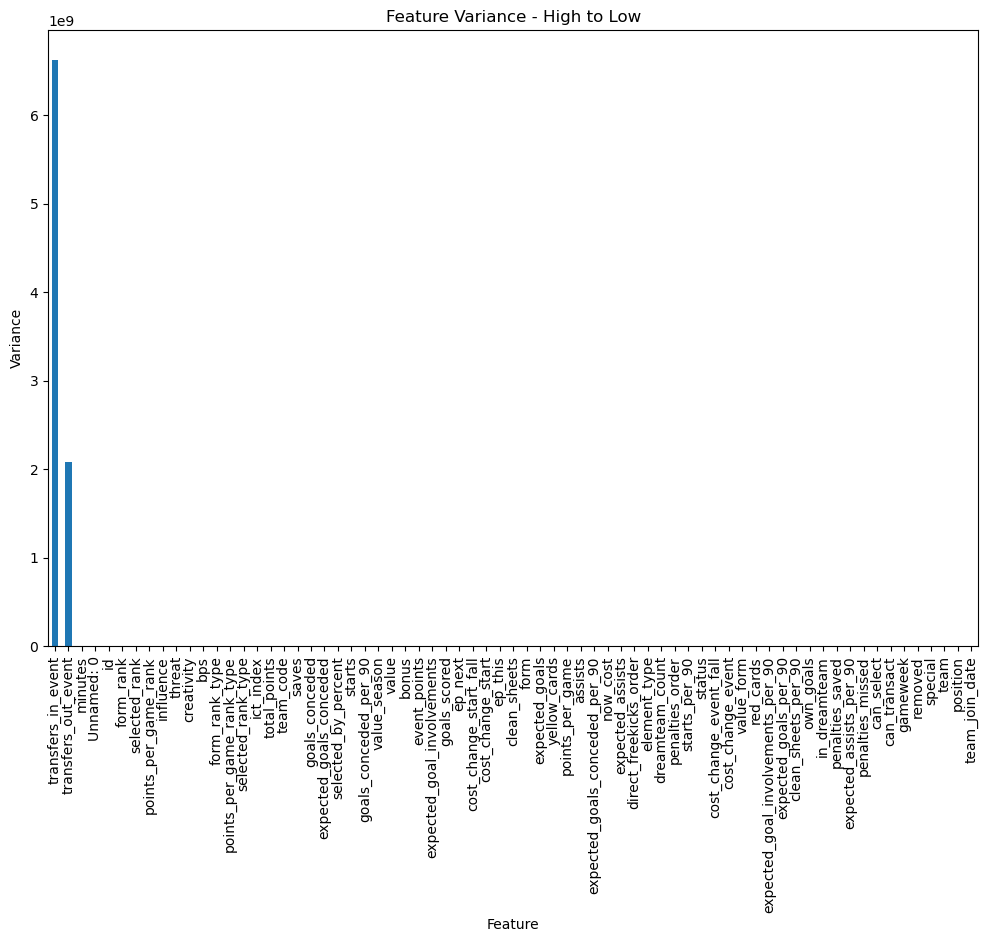

Selected high-variance features:
 ['Unnamed: 0', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'ep_next', 'ep_this', 'event_points', 'form', 'in_dreamteam', 'now_cost', 'points_per_game', 'selected_by_percent', 'status', 'team_code', 'total_points', 'transfers_in_event', 'transfers_out_event', 'value_form', 'value_season', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'expected_goals_per_90', 'expected_assists_per_90', 'expected_goal_involvements_per_90', 'expected_goals_conceded_per_90', 'goals_conceded_per_90', 'form_rank', 'form_rank_type', 'points_per_game_rank', 'points_per_game_rank_type', 'selected_rank', 'selected_rank_type', 'sta

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_variance_threshold.py:120: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


In [2000]:


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# Select only the numerical columns
data = players_df_cleaned.select_dtypes(include=['float64', 'int64']) 

# Calculate the variance for each feature
variances = data.var()

# Sort the features by variance in descending order
sorted_variances = variances.sort_values(ascending=False)

# Plot the features in order of high variance to low
plt.figure(figsize=(12, 8))
sorted_variances.plot(kind='bar')
plt.title('Feature Variance - High to Low')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

# Apply VarianceThreshold to filter features with low variance
# Set the variance threshold (e.g., 3000); you can adjust this value as needed
selector = VarianceThreshold(threshold=0)
selector.fit(data)

# Get the feature names that are kept after applying VarianceThreshold
high_variance_columns = data.columns[selector.get_support()]

# Filter out 'id' or any other irrelevant features
high_variance_columns = [col for col in high_variance_columns if col != 'id']

# Print the selected high-variance features
print("Selected high-variance features:\n", high_variance_columns)

# Selecting features with higher variance
data = data[high_variance_columns]

# Sort the high variance columns based on their variance values in descending order
high_variance_sorted = sorted_variances[high_variance_columns].sort_values(ascending=False)

# Print the sorted high-variance features
print("\nSorted High-Variance Features:\n", high_variance_sorted)

#Selecting features with higher variance
data = data[high_variance_sorted.index]



### Data Scaling using min/max


In [2002]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected features
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)


In [2003]:
data_scaled_df.columns

Index(['transfers_in_event', 'transfers_out_event', 'minutes', 'Unnamed: 0',
       'form_rank', 'selected_rank', 'points_per_game_rank', 'influence',
       'threat', 'creativity', 'bps', 'form_rank_type',
       'points_per_game_rank_type', 'selected_rank_type', 'ict_index',
       'total_points', 'team_code', 'saves', 'goals_conceded',
       'expected_goals_conceded', 'selected_by_percent', 'starts',
       'goals_conceded_per_90', 'value_season', 'value', 'bonus',
       'event_points', 'expected_goal_involvements', 'goals_scored', 'ep_next',
       'cost_change_start', 'cost_change_start_fall', 'ep_this',
       'clean_sheets', 'form', 'expected_goals', 'yellow_cards',
       'points_per_game', 'assists', 'expected_goals_conceded_per_90',
       'now_cost', 'expected_assists', 'direct_freekicks_order',
       'element_type', 'dreamteam_count', 'penalties_order', 'starts_per_90',
       'status', 'cost_change_event', 'cost_change_event_fall', 'value_form',
       'red_cards', 'exp

##  PCA

In [2005]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)  # You can adjust the number of components
data_pca = pca.fit_transform(data_scaled_df)

In [2006]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)  # Output will show the proportion of variance explained by each principal component

# Store the explained variance ratios into two variables
explained_variance_pc1 = round(pca.explained_variance_ratio_[0],2)  # Variance for PC1
explained_variance_pc2 = round(pca.explained_variance_ratio_[1],2)  # Variance for PC2
print(explained_variance_pc1) 

[0.49007775 0.08189024]
0.49


#### Checking for non-linearity to assign pca score

In [2008]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assume total_points is a Series containing the total points for each player
total_points = players_df['total_points']  # Replace with your actual column name

# Create a new DataFrame
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
pca_df['Total Points'] = total_points
pca_df['web_name'] = players_df['web_name']
pca_df['team'] = players_df['team']

pca_df['Total Points'] = pca_df['Total Points'].fillna(0)
pca_df['web_name'] = pca_df['web_name'].fillna(players_df['web_name'])
pca_df['team'] = pca_df['team'].fillna(players_df['team'])

print(f"Number of rows in players_df: {len(data)}")
print(f"Number of rows in pca_df: {len(pca_df)}")
print(players_df_cleaned['web_name'].isnull().sum())
print(pca_df.isnull().sum())

pca_df_cleaned = pca_df.copy()
# Replace dropna with a fillna approach for consistent indices
pca_df_cleaned['PC1'] = pca_df_cleaned['PC1'].fillna(0)  # Replace NaN with a default value, e.g., 0
pca_df_cleaned['Total Points'] = pca_df_cleaned['Total Points'].fillna(0)  # Replace NaN with a default value

X = pca_df_cleaned[['PC1']]
y = pca_df_cleaned['Total Points']

# Transform PC1 to polynomial features
poly = PolynomialFeatures(degree=2)  # You can change the degree as needed
X_poly = poly.fit_transform(X)

# Fit a polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Get predictions and calculate R² score
poly_predictions = poly_model.predict(X_poly)
poly_r2 = r2_score(y, poly_predictions)

# Fit a linear regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_predictions = linear_model.predict(X)
linear_r2 = r2_score(y, linear_predictions)

# Determine non-linearity based on R² scores
# If polynomial R² is significantly higher than linear R², we consider it non-linear
threshold = 0.01  # Adjust threshold based on your criteria
non_linearity = 1 if (poly_r2 - linear_r2 > threshold) else 0

# Print results
print(f'Polynomial R²: {poly_r2}')
print(f'Linear R²: {linear_r2}')
print(f'Non-linearity for PC1: {non_linearity}')


Number of rows in players_df: 443
Number of rows in pca_df: 443
0
PC1               0
PC2               0
Total Points      0
web_name        122
team            122
dtype: int64
Polynomial R²: 0.01290845043450084
Linear R²: 0.012679139364522807
Non-linearity for PC1: 0


In [2009]:
len(pca_df_cleaned)

443

### Handling non-linear relationship

Given the exponential relationship with total points, consider transforming PC1 using a logarithmic or polynomial transformation. This can help capture the non-linear relationship while still using a regression framework.

In [2078]:

non_linearity_pc1 = 1 if poly_r2 > linear_r2 else 0

# Calculate Scores based on non-linearity
if non_linearity_pc1 == 1:
    # PC1 is non-linear; use polynomial features
    poly = PolynomialFeatures(degree=2)  # Adjust degree as needed
    poly_features = poly.fit_transform(pca_df[['PC1']])  # This will include the constant term

    # Add polynomial features to the DataFrame
    pca_df[['PC1', 'PC1^2']] = poly_features[:, 1:]  # Ignore the first column (constant)

    # Calculate Score using polynomial feature of PC1 and original PC2
    pca_df['Score'] = (explained_variance_pc1 * pca_df['PC1^2']) + (explained_variance_pc2 * pca_df['PC2'])
    print("here")
else:
    # PC1 is linear; use original PC1
    pca_df['Score'] = (explained_variance_pc1 * pca_df['PC1']) + (explained_variance_pc2 * pca_df['PC2'])
    print("there")

players_df['Score'] = pca_df['Score']
# # Indices of Wolves in players_df and corresponding entries in pca_df
# wolves_indices = players_df[players_df['team'] == 'Wolves'].index
# print("Indices in players_df (Wolves):", wolves_indices)
# print("Indices in pca_df (Wolves):", pca_df.loc[wolves_indices].index)

print(f"Number of rows in players_df: {len(players_df)}")
print(f"Number of rows in pca_df: {len(pca_df)}")
print(players_df['web_name'].isnull().sum())
print(pca_df.isnull().sum())

# Debug
if (players_df['team'] == 'Spurs').any():
    filtered_players = players_df[players_df['team'] == "Spurs"]
    print(filtered_players[['web_name','team']])
    filtered_pca = pca_df[pca_df['team'] == "Spurs"]
    print(filtered_pca[['PC1', 'PC2','web_name','team','Score']])
    filtered_wolves = players_df[players_df['team'] == "Spurs"]
    print(filtered_wolves[['web_name','Score']])
    print(f"Number of rows in filtered_players: {len(filtered_players)}")
    print(f"Number of rows in filtered_pca: {len(filtered_pca)}")
    print(filtered_players['web_name'].isnull().sum())
    print(filtered_pca.isnull().sum())


here
Number of rows in players_df: 443
Number of rows in pca_df: 443
0
PC1               0
PC2               0
Total Points      0
web_name        122
team            122
PC1^2             0
Score             0
Cluster           0
dtype: int64
        web_name   team
81       Solanke  Spurs
478       Austin  Spurs
479    Bentancur  Spurs
480     Bergvall  Spurs
481     Bissouma  Spurs
485     Dragusin  Spurs
487      Forster  Spurs
488         Gray  Spurs
490      Johnson  Spurs
491   Kulusevski  Spurs
493     Maddison  Spurs
494  Pedro Porro  Spurs
495     Reguilón  Spurs
498     P.M.Sarr  Spurs
502          Son  Spurs
503       Spence  Spurs
504       Udogie  Spurs
508       Werner  Spurs
509     Whiteman  Spurs
608    Lankshear  Spurs
         PC1       PC2 web_name   team     Score
81  0.423918 -0.211036  Solanke  Spurs  0.071173
        web_name     Score
81       Solanke  0.071173
478       Austin       NaN
479    Bentancur       NaN
480     Bergvall       NaN
481     Bissouma   

Check:

## K-means clustering

Elbow Method

In [2016]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Fit K-means for a range of clusters
inertia = []  # To store the inertia values
k_values = range(1, 11)  # Adjust the range based on your needs

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)  # Using random_state for reproducibility
    kmeans.fit(data_scaled_df)  # Fit the model
    inertia.append(kmeans.inertia_)  # Store the inertia value


The optimal cluster is 2. And we know it's the best players cluster and worst players cluster. 

In [2018]:
# Fit K-means with the optimal number of clusters (k=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)  # Using random_state for reproducibility
if non_linearity_pc1:
    kmeans.fit(pca_df[['PC1','PC1^2', 'PC2']])  # Fit the model
else:
    kmeans.fit(pca_df[['PC1', 'PC2']])  # Fit the model

# Add cluster labels to your original DataFrame
pca_df['Cluster'] = kmeans.labels_


In [2019]:
import matplotlib.pyplot as plt

pca_df['web_name'] = players_df['web_name']  # Add the player names to the PCA DataFrame



In [2020]:
players_df.columns

Index(['Unnamed: 0', 'gameweek', 'id', 'web_name', 'team', 'position',
       'can_transact', 'can_select', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'code', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo',
       'points_per_game', 'removed', 'second_name', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team_code', 'total_points',
       'transfers_in', 'transfers_in_event', 'transfers_out',
       'transfers_out_event', 'value_form', 'value_season', 'region',
       'team_join_date', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'start

In [2021]:
pca_df.columns

Index(['PC1', 'PC2', 'Total Points', 'web_name', 'team', 'PC1^2', 'Score',
       'Cluster'],
      dtype='object')

In [2022]:
import numpy as np

# Assuming both pca_df and players_df have a common identifier 'player_id'
# Merge pca_df and players_df on 'player_id'
players_with_clusters = players_df.merge(pca_df[['web_name', 'Cluster', 'PC1']], on='web_name', how='left')

print( players_with_clusters.head())

# Calculate the average 'PC1' value for each cluster
cluster_avg = players_with_clusters.groupby('Cluster')['PC1'].mean()

# Identify the worst cluster (lowest average 'PC1')
worst_cluster = cluster_avg.idxmin()

# Filter out players from the worst cluster
players_df_filtered = players_with_clusters[players_with_clusters['Cluster'] != worst_cluster]



   Unnamed: 0  gameweek  id  web_name     team    position  can_transact  \
0           1         1   2   G.Jesus  Arsenal     Forward          True   
1           2         1   3   Gabriel  Arsenal    Defender          True   
2           3         1   4   Havertz  Arsenal     Forward          True   
3           5         1   6  J.Timber  Arsenal    Defender          True   
4           6         1   7  Jorginho  Arsenal  Midfielder          True   

   can_select  chance_of_playing_next_round  chance_of_playing_this_round  \
0        True                         100.0                         100.0   
1        True                         100.0                         100.0   
2        True                         100.0                         100.0   
3        True                         100.0                         100.0   
4        True                           NaN                           NaN   

     code  cost_change_event  cost_change_event_fall  cost_change_start  \
0  20

In [2023]:
players_filtered.columns

Index(['Unnamed: 0', 'gameweek', 'id', 'web_name', 'team', 'position',
       'can_transact', 'can_select', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'code', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo',
       'points_per_game', 'removed', 'second_name', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team_code', 'total_points',
       'transfers_in', 'transfers_in_event', 'transfers_out',
       'transfers_out_event', 'value_form', 'value_season', 'region',
       'team_join_date', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'start

In [2024]:
players_df_filtered = add_average_fdr(players_df_filtered)

Index(['Unnamed: 0', 'gameweek', 'id', 'web_name', 'team', 'position',
       'can_transact', 'can_select', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'code', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo',
       'points_per_game', 'removed', 'second_name', 'selected_by_percent',
       'special', 'squad_number', 'status', 'team_code', 'total_points',
       'transfers_in', 'transfers_in_event', 'transfers_out',
       'transfers_out_event', 'value_form', 'value_season', 'region',
       'team_join_date', 'minutes', 'goals_scored', 'assists', 'clean_sheets',
       'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
       'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence',
       'creativity', 'threat', 'ict_index', 'start

/var/folders/dy/ysjjzh0121qb38fzyck4zbdh0000gn/T/ipykernel_83187/1545660302.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_df['team_id'] = players_df['team'].map(reversed_team_mapping)


In [2025]:

# Calculate the new score
# Set the weight for adjusted_fdr
weight = 2  # Adjust this value based on how much you want to influence the score

# Calculate the new score
players_df_filtered['adjusted_score'] = players_df_filtered['Score'] + (weight * players_df_filtered['adjusted_fdr'])

# Optional: Display the updated DataFrame to check the new scores
print(players_df_filtered[['Score', 'adjusted_fdr', 'adjusted_score']].head())

# Sort the filtered players_df by Score in descending order
players_df_filtered_sorted = players_df_filtered.sort_values(by='Score', ascending=False)

# Display the sorted DataFrame
print(players_df_filtered_sorted[['web_name', 'Score']])

# Position mapping
position_mapping = {1: 'goalkeeper', 2: 'defender', 3: 'midfielder', 4: 'forward'}
players_df_filtered_sorted['position'] = players_df_filtered_sorted['element_type'].map(position_mapping)

players_df_filtered_sorted = add_average_fdr(players_df_filtered_sorted)



      Score  adjusted_fdr  adjusted_score
0  1.000963           5.0       11.000963
1  1.163246           5.0       11.163246
2  0.540007           5.0       10.540007
3  0.514454           5.0       10.514454
4  0.742514           5.0       10.742514
        web_name     Score
40     Mykolenko  5.154976
22     Estupiñan  3.808283
64   Wan-Bissaka  2.707819
53          Faes  2.422503
60         Lewis  2.152843
..           ...       ...
181     O’Reilly       NaN
182      Dibling       NaN
183    Lankshear       NaN
184     Szmodics       NaN
185      Collyer       NaN

[186 rows x 2 columns]
Index(['Unnamed: 0', 'gameweek', 'id', 'web_name', 'team', 'position',
       'can_transact', 'can_select', 'chance_of_playing_next_round',
       'chance_of_playing_this_round', 'code', 'cost_change_event',
       'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall',
       'dreamteam_count', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'in_dreamteam', 'ne

In [2026]:
# Filtering players_df to show all rows where the team is 'Wolves'
wolves_players_df = players_df_filtered_sorted[players_df_filtered_sorted['team'] == "Wolves"]
wolves_players_df.head()

,Unnamed: 0,gameweek,id,web_name,team,position,can_transact,can_select,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,ep_next,ep_this,event_points,first_name,form,in_dreamteam,news,news_added,now_cost,photo,points_per_game,removed,second_name,selected_by_percent,special,squad_number,status,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,region,team_join_date,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,direct_freekicks_order,penalties_order,element_type,Score,Cluster,PC1,team_id,adjusted_fdr,average_fdr,adjusted_score,adjusted_fdr_avg,average_fdr_avg
127,532,1,533,Aït-Nouri,Wolves,defender,True,True,100.0,0.0,448514,0,0,3,-3,1,0.4,0.0,0,Rayan,0.4,False,NaN,2024-12-14T21:30:08.057496Z,4.8,448514.jpg,2.5,False,Aït-Nouri,6.6,False,NaN,a,39,40,1973559,7457,1536683,96538,0.1,8.3,3.0,2021-07-09,1369,3,3,1,39,0,0,0,4,1,0,2,128,372.2,209.2,184.0,76.7,16,1.35,1.00,2.35,25.74,0.09,0.07,0.16,1.69,2.56,345,110,179,55,60,21,1.05,0.07,NaN,NaN,2,NaN,NaN,NaN,20.0,2.0,5.0,NaN,2.0,5.0
128,534,1,535,Bellegarde,Wolves,midfielder,True,True,NaN,NaN,231057,0,0,0,0,0,1.8,1.8,1,Jean-Ricner,1.8,False,NaN,NaN,5.0,231057.jpg,2.2,False,Bellegarde,0.1,False,NaN,a,39,33,13776,49,14090,451,0.4,6.6,73.0,2023-09-01,724,1,2,2,17,0,0,0,2,0,0,0,105,120.4,141.0,82.0,33.8,9,0.55,0.75,1.30,13.41,0.07,0.09,0.16,1.67,2.11,189,91,226,97,494,187,1.12,0.25,1.0,NaN,3,NaN,NaN,NaN,20.0,2.0,5.0,NaN,2.0,5.0
129,535,1,536,Bentley,Wolves,goalkeeper,True,True,NaN,NaN,79602,0,0,0,0,0,0.0,0.0,0,Daniel,0.0,False,NaN,NaN,4.0,79602.jpg,0.0,False,Bentley,1.4,False,NaN,a,39,0,53037,371,117090,3178,0.0,0.0,241.0,2023-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,417,41,501,48,176,24,0.00,0.00,NaN,NaN,1,NaN,NaN,NaN,20.0,2.0,5.0,NaN,2.0,5.0
130,538,1,539,Chiwome,Wolves,forward,True,True,100.0,100.0,589507,0,0,0,0,0,0.0,0.0,0,Leon,0.0,False,NaN,2024-09-10T11:40:34.472554Z,4.5,589507.jpg,0.0,False,Chiwome,2.2,False,NaN,a,39,0,528053,11788,338155,23460,0.0,0.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,611,58,657,63,134,22,0.00,0.00,NaN,NaN,4,NaN,NaN,NaN,20.0,2.0,5.0,NaN,2.0,5.0
131,539,1,540,Cundle,Wolves,midfielder,True,True,NaN,NaN,245923,0,0,0,0,0,0.0,0.0,0,Luke,0.0,False,NaN,NaN,4.5,245923.jpg,0.0,False,Cundle,0.2,False,NaN,a,39,0,32271,186,31723,758,0.0,0.0,241.0,2019-07-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,551,210,603,248,364,124,0.00,0.00,NaN,NaN,3,NaN,NaN,NaN,20.0,2.0,5.0,NaN,2.0,5.0
